使用一下三阶多项式来生成训练和测试数据的标签：
$$
y = 5 + 1.2x - 3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+ \epsilon \quad where \quad \epsilon \sim N(0, 0.1^2)
$$

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集
为 train set 和 test set各生成100个样本

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 更高阶的都是噪音项

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# 用于测试 np.power 和广播机制
A = np.array([1, 2, 3, 4])
B = np.array([0, 1, 2, 3]).reshape(4, -1)
np.power(A, B), A, B

(array([[ 1,  1,  1,  1],
        [ 1,  2,  3,  4],
        [ 1,  4,  9, 16],
        [ 1,  8, 27, 64]], dtype=int32),
 array([1, 2, 3, 4]),
 array([[0],
        [1],
        [2],
        [3]]))

In [4]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.9871],
         [ 0.0999]]),
 tensor([[ 1.0000e+00, -1.9871e+00,  1.9743e+00, -1.3077e+00,  6.4963e-01,
          -2.5818e-01,  8.5503e-02, -2.4272e-02,  6.0288e-03, -1.3311e-03,
           2.6450e-04, -4.7781e-05,  7.9122e-06, -1.2094e-06,  1.7166e-07,
          -2.2740e-08,  2.8242e-09, -3.3011e-10,  3.6442e-11, -3.8113e-12],
         [ 1.0000e+00,  9.9928e-02,  4.9928e-03,  1.6631e-04,  4.1546e-06,
           8.3032e-08,  1.3829e-09,  1.9741e-11,  2.4658e-13,  2.7378e-15,
           2.7359e-17,  2.4853e-19,  2.0696e-21,  1.5909e-23,  1.1355e-25,
           7.5646e-28,  4.7244e-30,  2.7771e-32,  1.5417e-34,  8.1084e-37]]),
 tensor([-11.5570,   5.0255]))

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0219135  1.2169456 -3.4023657  5.60364  ]]


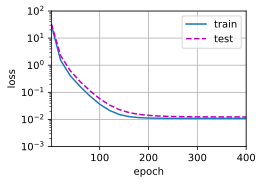

In [7]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.0442202 4.5970035]]


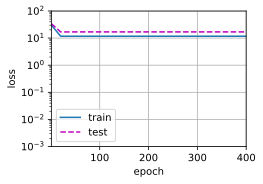

In [8]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0184073e+00  1.3188013e+00 -3.3722842e+00  5.0369830e+00
  -1.4641745e-01  1.5651892e+00  8.6094685e-02  3.6818707e-01
   2.0645759e-01 -1.1707209e-01  9.5034614e-02  4.5669544e-02
  -1.7427284e-01  1.6926694e-01  9.4250031e-03 -7.0465840e-02
  -4.6547111e-03  8.8469446e-02 -6.5087259e-02  4.7153324e-02]]


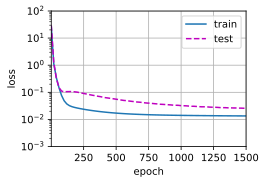

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)